In [4]:
from torchsummary                 import summary
from tqdm                         import tqdm
from src.data.to_tensor           import ToTensor
from src.data.mrw_dataset         import MRWDataset
from src.data.create_data_loaders import create_data_loaders
from src.nn.archs                 import CNN_C2
from src.nn.results.utils         import (get_all_predictions, analyse_predictions, 
                                            plot_predictions, plot_losses)
from src.nn.results.utils.get_MSEs_file import get_MSEs

import random
import torch
import torch.nn           as nn
import numpy              as np
import src.ctes.num_ctes  as nctes
import src.ctes.str_ctes  as sctes
import src.ctes.path_ctes as pctes

In [5]:
builder = CNN_C2

In [6]:
data_path = pctes.DATAPATH
timestamp = "2024_01_07__18_45_55"
arch_name = builder.__name__
hyperparams_path = f"../../../data/hyperparams_{arch_name}_{timestamp}.npz"
model_path = f"../../../data/model_{arch_name}_{timestamp}.pt"
losses_path = f"../../../data/losses_{arch_name}_{timestamp}.npz"
losses_img_path = f"../../../data/losses_{arch_name}_{timestamp}.png"

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cpu


In [8]:
hyperparams = np.load(hyperparams_path)
print(hyperparams)

NpzFile '../../../data/hyperparams_CNN_ALL_2024_01_07__18_45_55.npz' with keys: len, test_size, valid_size, epochs, batch_size...


In [9]:
seed = int(hyperparams[sctes.SEED])
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [10]:
sample_size = nctes.LEN_SAMPLE
model = builder(input_size=sample_size, dropout_probs=hyperparams[sctes.DROPOUT_PROBS])
model.to(device=device)
model.load_state_dict(torch.load(model_path, map_location=device))
summary(model, (1, sample_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Dropout: 1-2                           [-1, 16, 32768]           --
├─Sequential: 1-3                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-4                         [-1, 32, 16384]           --
├─Dropout: 1-5                           [-1, 32, 16384]           --
├─Sequential: 1-6                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─Ba

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Dropout: 1-2                           [-1, 16, 32768]           --
├─Sequential: 1-3                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-4                         [-1, 32, 16384]           --
├─Dropout: 1-5                           [-1, 32, 16384]           --
├─Sequential: 1-6                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─Ba

In [11]:
transform = ToTensor()
labels    = hyperparams.get(sctes.LABELS, [sctes.C1, sctes.C2, sctes.L, sctes.EPSILON])

data      = MRWDataset(data_path, transform, sample_size, labels)

FileNotFoundError: [Errno 2] No such file or directory: '/users/local/f22dimar/TurbNNGen/data/MRW.npz'

In [ ]:
batch_size = int(hyperparams[sctes.BATCH_SIZE])
valid_size = float(hyperparams[sctes.VALID_SIZE])
test_size = float(hyperparams[sctes.TEST_SIZE])

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

In [ ]:
losses = np.load(losses_path)
train_losses = losses[sctes.TRAIN]
valid_losses = losses[sctes.VAL]

In [ ]:
criterion = nn.MSELoss()
print(f"{criterion = }")

criterion = MSELoss()


In [ ]:
data_len = int(hyperparams[sctes.LEN])
test_len = int(hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])
valid_len = int((hyperparams[sctes.LEN] - hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])*hyperparams[sctes.VALID_SIZE])
train_len = data_len - test_len - valid_len

if sctes.MODEL_NAME in hyperparams :
    print(f"Model name       = {hyperparams[sctes.MODEL_NAME]}")
print(f"Sample length    = {nctes.LEN_SAMPLE}")
print(f"Total samples    = {data_len}")
print(f"Train samples    = {train_len}")
print(f"Valid samples    = {valid_len}")
print(f"Test samples     = {test_len}")
print(f"Batch size       = {int(hyperparams[sctes.BATCH_SIZE])}")
print(f"Number of epochs = {int(hyperparams[sctes.EPOCHS])}")
print(f"Loss             = {''.join(hyperparams[sctes.CRITERION].tolist())}")
print(f"Optimizer        = {''.join(hyperparams[sctes.OPTIMIZER].tolist())}")
print(f"Learning rate    = {float(hyperparams[sctes.LR])}")
print(f"Seed             = {float(hyperparams[sctes.SEED])}")
if sctes.DROPOUT_PROBS in hyperparams:
    print(f"Dropout probas    = {hyperparams[sctes.DROPOUT_PROBS].tolist()}")
print(f"Labels           = {hyperparams.get(sctes.LABELS, [sctes.C1, sctes.C2, sctes.L, sctes.EPSILON])}")

Model name       = Dropout probas 0.5 and L2 regularization
Sample length    = 32768
Total samples    = 12800
Train samples    = 8192
Valid samples    = 2048
Test samples     = 2560
Batch size       = 6
Number of epochs = 50
Loss             = WeightedMSELoss(weights=tensor([1.0000, 1.5000, 1.5000, 1.5000]))
Optimizer        = Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.001
)
Learning rate    = 0.001
Seed             = 42.0
Dropout probas    = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Labels           = ['c1', 'c2', 'L', 'EPSILON']


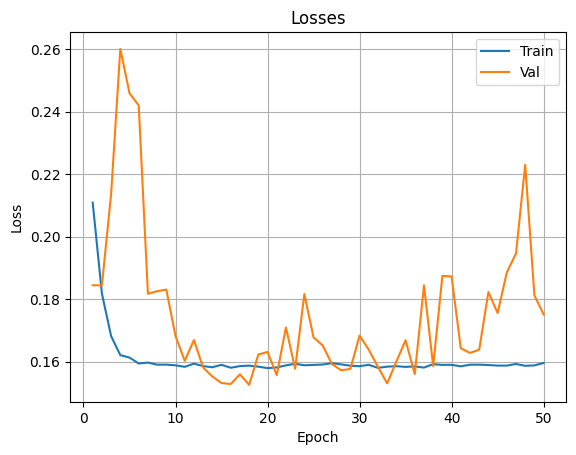

In [ ]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])
# plt.savefig(losses_img_path)

In [ ]:
targets, preds, output_losses  = get_all_predictions(model, test_loader, device, criterion, labels)

  0%|          | 0/427 [00:00<?, ?it/s]

100%|██████████| 427/427 [00:15<00:00, 26.84it/s]


In [ ]:
analyse_predictions(targets, preds)

True values of c1 and their count : 
0.0: 665 occurrences
0.3333333432674408: 625 occurrences
0.6666666865348816: 635 occurrences
1.0: 635 occurrences

Predicted values of c1 and their count: 
0.10690730810165405: 1 occurrences
0.11223728954792023: 1 occurrences
0.11683697998523712: 1 occurrences
0.11981473118066788: 1 occurrences
0.12177120894193649: 1 occurrences
0.1241915374994278: 1 occurrences
0.12824870645999908: 1 occurrences
0.12965402007102966: 1 occurrences
0.13025128841400146: 1 occurrences
0.13029764592647552: 1 occurrences
0.13165077567100525: 1 occurrences
0.13329172134399414: 1 occurrences
0.13368132710456848: 1 occurrences
0.1348518431186676: 1 occurrences
0.1365433782339096: 1 occurrences
0.13828584551811218: 1 occurrences
0.14101770520210266: 1 occurrences
0.14223837852478027: 1 occurrences
0.14334067702293396: 1 occurrences
0.14441463351249695: 1 occurrences
0.1451733559370041: 1 occurrences
0.14646399021148682: 1 occurrences
0.14663806557655334: 1 occurrences
0.1473

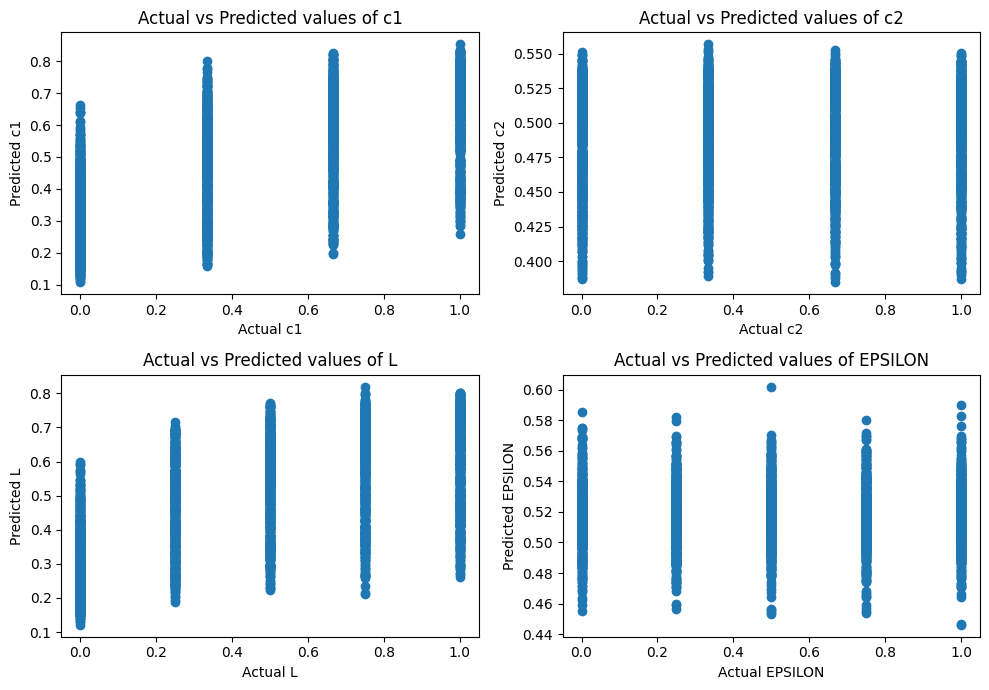

In [ ]:
plot_predictions(targets, preds, labels)

In [ ]:
total_test_loss, mean_output_losses = get_MSEs(targets, preds, output_losses, labels, device, criterion)
print("Total Test MSE = {:0.4f}".format(total_test_loss))
print("")
print("Test MSE for each output:")
for key, value in mean_output_losses.items():
    print(f"{key}: {value:.4f}")

2560it [00:00, 8283.58it/s]


In [ ]:
n_show = 10
print(f"{n_show} Worst Results ==>")
for i in range(n_show):
    print(f"              c1         c2         L         epsilon")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[i]]}")
    print(f"MSE         = {'{:0.4f}'.format(test_losses[i])}")
    print()

10 Worst Results ==>
              c1         c2         L         epsilon
Target      = ['0.0000', '1.0000', '1.0000', '0.0000']
Prediction  = ['0.3093', '0.4398', '0.2983', '0.5068']
MSE         = 0.2897

              c1         c2         L         epsilon
Target      = ['0.0000', '1.0000', '1.0000', '0.0000']
Prediction  = ['0.3670', '0.4205', '0.3661', '0.5178']
MSE         = 0.2851

              c1         c2         L         epsilon
Target      = ['0.0000', '1.0000', '1.0000', '0.0000']
Prediction  = ['0.5160', '0.4691', '0.4367', '0.5112']
MSE         = 0.2817

              c1         c2         L         epsilon
Target      = ['1.0000', '1.0000', '0.0000', '0.0000']
Prediction  = ['0.3695', '0.4499', '0.3969', '0.5013']
MSE         = 0.2772

              c1         c2         L         epsilon
Target      = ['0.0000', '1.0000', '1.0000', '0.0000']
Prediction  = ['0.2900', '0.4684', '0.2699', '0.4553']
MSE         = 0.2768

              c1         c2         L         eps

In [ ]:
n_show = 10
print(f"{n_show} Best Results ==>")
for i in range(n_show, 0, -1):
    print(f"              {[label + '    ' for label in labels]}")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[-i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[-i]]}")
    print(f"WeightedMSE = {'{:0.4f}'.format(test_losses[-i])}")
    print()

10 Best Results ==>
              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.6667', '0.6667', '0.5000', '0.5000']
Prediction  = ['0.6507', '0.5297', '0.6272', '0.5463']
WeightedMSE = 0.0093

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.3333', '0.6667', '0.5000', '0.5000']
Prediction  = ['0.4315', '0.5027', '0.4785', '0.4838']
WeightedMSE = 0.0093

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.6667', '0.6667', '0.5000', '0.5000']
Prediction  = ['0.5672', '0.5187', '0.5562', '0.4882']
WeightedMSE = 0.0088

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.6667', '0.3333', '0.5000', '0.5000']
Prediction  = ['0.5691', '0.4832', '0.4903', '0.5062']
WeightedMSE = 0.0080

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.3333', '0.3333', '0.5000', '0.5000']
Prediction  = ['0.3998', '0.4305', '0.3712', '0.5330']
WeightedMSE = 0.0079

              ['c1    ', 